In [1]:
import warnings
warnings.filterwarnings("ignore")
# Libraries to read and manipulate data
import pandas as pd
import numpy as np

# libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from statsmodels.api import OLS, add_constant

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier

#libraries for convenience
from datetime import datetime
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
data = pd.read_csv('../Resources/Reg_season_games.csv')
#slightly modified version of attendance data
attendence_data = pd.read_csv('../Resources/attendance_marced.csv')
# copying data to preserve original
games_data = data.copy()
attendence_data.drop(['Unnamed: 0'],axis= 1)
attendence_data

,Unnamed: 0,HOME_TEAM_NAME,Year,Attendance
0,0,Pistons,2004,872902
1,1,Mavericks,2004,825594
2,2,Bulls,2004,809177
3,3,76ers,2004,788128
4,4,NY Knicks,2004,785739
...,...,...,...,...
534,554,Magic,2022,622881
535,555,Spurs,2022,615588
536,556,Thunder,2022,595112
537,557,Kings,2022,577583


In [3]:
games_data

,Unnamed: 0,GAME_DATE,HOME_TEAM_ID,HOME_TEAM_NAME,2pointer_PCT_HOME,3pointer_PCT_HOME,FreeThrow_PCT_HOME,Assists_HOME,Rebounds_HOME,VISITOR_TEAM_ID,VISITOR_TEAM_NAME,2pointer_PCT_AWAY,3pointer_PCT_AWAY,FreeThrow_PCT_AWAY,Assists_AWAY,Rebounds_AWAY,HOME_TEAM_WINS
0,17131,2004-04-14,1610612746,Clippers,0.423,0.214,0.727,17.000,37.000,1610612760,Thunder,0.542,0.375,1.000,32.000,34.000,0
1,17132,2004-04-14,1610612759,Spurs,0.424,0.100,0.679,15.000,58.000,1610612743,Nuggets,0.325,0.222,0.611,11.000,47.000,1
2,17133,2004-04-14,1610612754,Pacers,0.420,0.316,0.794,24.000,58.000,1610612741,Bulls,0.420,0.357,0.667,20.000,41.000,1
3,17134,2004-04-14,1610612764,Wizards,0.375,0.211,0.714,13.000,39.000,1610612740,Pelicans,0.451,0.364,0.600,24.000,48.000,0
4,17135,2004-04-14,1610612752,Knicks,0.481,0.400,0.714,13.000,42.000,1610612739,Cavaliers,0.488,0.364,0.900,22.000,40.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21609,2271,2020-12-25,1610612738,Celtics,0.378,0.296,0.684,23.000,47.000,1610612751,Nets,0.539,0.517,0.839,21.000,43.000,0
21610,2272,2020-12-23,1610612754,Pacers,0.489,0.235,0.724,28.000,50.000,1610612752,Knicks,0.459,0.429,0.739,25.000,40.000,1
21611,2273,2020-12-23,1610612755,76ers,0.471,0.286,0.767,22.000,47.000,1610612764,Wizards,0.459,0.481,0.696,28.000,40.000,1
21612,2274,2020-12-23,1610612741,Bulls,0.414,0.229,0.857,20.000,37.000,1610612737,Hawks,0.538,0.400,0.828,24.000,46.000,0


In [4]:
games_data = games_data.drop(['Unnamed: 0','HOME_TEAM_ID'],axis=1)

In [5]:
games_data['GAME_DATE'] = pd.to_datetime(games_data['GAME_DATE'],yearfirst=True)

In [6]:
games_data.dtypes

GAME_DATE             datetime64[ns]
HOME_TEAM_NAME                object
2pointer_PCT_HOME            float64
3pointer_PCT_HOME            float64
FreeThrow_PCT_HOME           float64
Assists_HOME                 float64
Rebounds_HOME                float64
VISITOR_TEAM_ID                int64
VISITOR_TEAM_NAME             object
2pointer_PCT_AWAY            float64
3pointer_PCT_AWAY            float64
FreeThrow_PCT_AWAY           float64
Assists_AWAY                 float64
Rebounds_AWAY                float64
HOME_TEAM_WINS                 int64
dtype: object

In [7]:
games_data['GAME_DATE'] = pd.DatetimeIndex(games_data['GAME_DATE']).year

In [8]:
games_data

,GAME_DATE,HOME_TEAM_NAME,2pointer_PCT_HOME,3pointer_PCT_HOME,FreeThrow_PCT_HOME,Assists_HOME,Rebounds_HOME,VISITOR_TEAM_ID,VISITOR_TEAM_NAME,2pointer_PCT_AWAY,3pointer_PCT_AWAY,FreeThrow_PCT_AWAY,Assists_AWAY,Rebounds_AWAY,HOME_TEAM_WINS
0,2004,Clippers,0.423,0.214,0.727,17.000,37.000,1610612760,Thunder,0.542,0.375,1.000,32.000,34.000,0
1,2004,Spurs,0.424,0.100,0.679,15.000,58.000,1610612743,Nuggets,0.325,0.222,0.611,11.000,47.000,1
2,2004,Pacers,0.420,0.316,0.794,24.000,58.000,1610612741,Bulls,0.420,0.357,0.667,20.000,41.000,1
3,2004,Wizards,0.375,0.211,0.714,13.000,39.000,1610612740,Pelicans,0.451,0.364,0.600,24.000,48.000,0
4,2004,Knicks,0.481,0.400,0.714,13.000,42.000,1610612739,Cavaliers,0.488,0.364,0.900,22.000,40.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21609,2020,Celtics,0.378,0.296,0.684,23.000,47.000,1610612751,Nets,0.539,0.517,0.839,21.000,43.000,0
21610,2020,Pacers,0.489,0.235,0.724,28.000,50.000,1610612752,Knicks,0.459,0.429,0.739,25.000,40.000,1
21611,2020,76ers,0.471,0.286,0.767,22.000,47.000,1610612764,Wizards,0.459,0.481,0.696,28.000,40.000,1
21612,2020,Bulls,0.414,0.229,0.857,20.000,37.000,1610612737,Hawks,0.538,0.400,0.828,24.000,46.000,0


In [9]:
yearray = np.arange(2004,2022,1)
# lazy code writing via for loop
# for year in yearray:
#     print(f'season_{year} = games_data.loc[(games_data[] == {year})]')
# print('searray = [')
# for year in yearray:
#     print(f'season_{year},')
# print(']')

In [10]:
season_2004 = games_data.loc[(games_data['GAME_DATE'] == 2004)]
season_2005 = games_data.loc[(games_data['GAME_DATE'] == 2005)]
season_2006 = games_data.loc[(games_data['GAME_DATE'] == 2006)]
season_2007 = games_data.loc[(games_data['GAME_DATE'] == 2007)]
season_2008 = games_data.loc[(games_data['GAME_DATE'] == 2008)]
season_2009 = games_data.loc[(games_data['GAME_DATE'] == 2009)]
season_2010 = games_data.loc[(games_data['GAME_DATE'] == 2010)]
season_2011 = games_data.loc[(games_data['GAME_DATE'] == 2011)]
season_2012 = games_data.loc[(games_data['GAME_DATE'] == 2012)]
season_2013 = games_data.loc[(games_data['GAME_DATE'] == 2013)]
season_2014 = games_data.loc[(games_data['GAME_DATE'] == 2014)]
season_2015 = games_data.loc[(games_data['GAME_DATE'] == 2015)]
season_2016 = games_data.loc[(games_data['GAME_DATE'] == 2016)]
season_2017 = games_data.loc[(games_data['GAME_DATE'] == 2017)]
season_2018 = games_data.loc[(games_data['GAME_DATE'] == 2018)]
season_2019 = games_data.loc[(games_data['GAME_DATE'] == 2019)]
season_2020 = games_data.loc[(games_data['GAME_DATE'] == 2020)]
season_2021 = games_data.loc[(games_data['GAME_DATE'] == 2021)]

In [11]:
searray = [season_2004,season_2005,season_2006,
    season_2007,season_2008,season_2009,season_2010,
    season_2011,season_2012,season_2013,season_2014,
    season_2015,season_2016,season_2017,season_2018,
    season_2019,season_2020,season_2021,]

In [12]:
def season_maker(df,year):
    season_home = df[['HOME_TEAM_NAME','2pointer_PCT_HOME','3pointer_PCT_HOME','FreeThrow_PCT_HOME','Assists_HOME','Rebounds_HOME']]
    season_home_W = df[['HOME_TEAM_NAME', 'HOME_TEAM_WINS']]
    season_home = season_home.groupby(['HOME_TEAM_NAME']).mean()
    season_home_W = season_home_W.groupby(['HOME_TEAM_NAME']).sum()
    season_away = df[['VISITOR_TEAM_NAME','2pointer_PCT_AWAY','3pointer_PCT_AWAY','FreeThrow_PCT_AWAY','Assists_AWAY','Rebounds_AWAY']]
    season_away_W = df[['VISITOR_TEAM_NAME', 'HOME_TEAM_WINS']]
    season_away_W['AWAY_TEAM_WINS'] = season_away_W['HOME_TEAM_WINS'].replace(({0: 1, 1: 0}))
    season_away_W = season_away_W.drop(['HOME_TEAM_WINS'],axis=1)
    season_away = season_away.groupby(['VISITOR_TEAM_NAME']).mean()
    season_away_W = season_away_W.groupby(['VISITOR_TEAM_NAME']).sum()
    season_inprogress = pd.concat([season_home, season_away, season_home_W, season_away_W], axis=1, join='inner')
    season_inprogress['TEAM_NAME'] = season_inprogress.index
    season_inprogress.reset_index(inplace=True,drop=True)
    season_inprogress['2pointer_PCT_AVG'] = (season_inprogress['2pointer_PCT_HOME'] + season_inprogress['2pointer_PCT_AWAY'])/2
    season_inprogress['3pointer_PCT_AVG'] = (season_inprogress['3pointer_PCT_HOME'] + season_inprogress['3pointer_PCT_AWAY'])/2
    season_inprogress['FreeThrow_PCT_AVG'] = (season_inprogress['FreeThrow_PCT_HOME'] + season_inprogress['FreeThrow_PCT_AWAY'])/2
    season_inprogress['Assists_AVG'] = (season_inprogress['Assists_HOME'] + season_inprogress['Assists_AWAY'])/2
    season_inprogress['Rebounds_AVG'] = (season_inprogress['Rebounds_HOME'] + season_inprogress['Rebounds_AWAY'])/2
    season_inprogress['WINS'] = season_inprogress['HOME_TEAM_WINS'] + season_inprogress['AWAY_TEAM_WINS']
    season_cumulative = season_inprogress[['TEAM_NAME','2pointer_PCT_AVG','3pointer_PCT_AVG','FreeThrow_PCT_AVG','Assists_AVG','Rebounds_AVG','WINS']]
    season_cumulative['Year'] = year
    return season_cumulative
    

In [13]:
combined_df = pd.DataFrame()
for indx in np.arange(0,len(searray),1):
    searray[indx] = season_maker(searray[indx],yearray[indx])
    combined_df = combined_df.append(searray[indx])
searray[10]

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year
0,76ers,0.425,0.298,0.697,20.682,41.523,14,2014
1,Bucks,0.456,0.366,0.749,22.250,40.904,25,2014
2,Bulls,0.445,0.360,0.778,22.858,44.554,58,2014
3,Cavaliers,0.449,0.353,0.753,22.419,43.035,41,2014
4,Celtics,0.439,0.320,0.780,23.527,43.274,23,2014
5,Clippers,0.479,0.373,0.748,24.952,42.040,58,2014
6,Grizzlies,0.471,0.364,0.751,22.359,42.306,60,2014
7,Hawks,0.460,0.361,0.786,24.835,39.580,43,2014
8,Heat,0.484,0.353,0.753,20.900,36.699,44,2014
9,Hornets,0.446,0.345,0.744,22.022,42.098,39,2014


In [14]:
combined_df

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year
0,76ers,0.430,0.324,0.761,19.808,41.987,32,2004
1,Bucks,0.448,0.359,0.775,21.982,41.930,35,2004
2,Bulls,0.421,0.338,0.717,21.638,43.346,23,2004
3,Cavaliers,0.439,0.330,0.771,22.080,43.525,42,2004
4,Celtics,0.450,0.327,0.764,20.167,40.070,33,2004
...,...,...,...,...,...,...,...,...
25,Thunder,0.442,0.340,0.732,22.039,45.686,21,2021
26,Timberwolves,0.451,0.352,0.762,25.794,43.471,21,2021
27,Trail Blazers,0.456,0.387,0.822,21.176,44.647,40,2021
28,Warriors,0.471,0.377,0.782,27.850,43.147,37,2021


In [15]:
attendence_data = attendence_data.drop(['Unnamed: 0'],axis=1)
attendence_data

,HOME_TEAM_NAME,Year,Attendance
0,Pistons,2004,872902
1,Mavericks,2004,825594
2,Bulls,2004,809177
3,76ers,2004,788128
4,NY Knicks,2004,785739
...,...,...,...
534,Magic,2022,622881
535,Spurs,2022,615588
536,Thunder,2022,595112
537,Kings,2022,577583


In [16]:
attendence_data.sort_values(by=['HOME_TEAM_NAME','Year'], inplace=True, ascending=True)
attendence_data['Year'] = attendence_data['Year'].replace(({2022: 2021}))
attendence_data.HOME_TEAM_NAME.value_counts()
#filling missing attendance number with a mean average.
new_row = {'HOME_TEAM_NAME':'Hornets', 'Year':2004, 'Attendance':634968}
#append row to the dataframe
attendence_data = attendence_data.append(new_row, ignore_index=True)
attendence_data.sort_values(by=['HOME_TEAM_NAME','Year'], inplace=True, ascending=True)
attendence_data.reset_index(inplace=True,drop=True)
print(attendence_data.to_string())

    HOME_TEAM_NAME  Year  Attendance
0            76ers  2004      788128
1            76ers  2005      732686
2            76ers  2006      677278
3            76ers  2007      608603
4            76ers  2008      609675
5            76ers  2009      647898
6            76ers  2010      583219
7            76ers  2011      604823
8            76ers  2012      577597
9            76ers  2013      685412
10           76ers  2014      568632
11           76ers  2015      571572
12           76ers  2016      610121
13           76ers  2017      710557
14           76ers  2018      833503
15           76ers  2019      838092
16           76ers  2020      639491
17           76ers  2021      846867
18           Bucks  2004      690180
19           Bucks  2005      637009
20           Bucks  2006      681337
21           Bucks  2007      663629
22           Bucks  2008      639421
23           Bucks  2009      630976
24           Bucks  2010      619453
25           Bucks  2011      631910
2

In [17]:
combined_df.sort_values(by=['TEAM_NAME','Year'], inplace=True, ascending=True)
combined_df.reset_index(inplace=True,drop=True)
print(combined_df.to_string())
combined_df.TEAM_NAME.value_counts()

         TEAM_NAME  2pointer_PCT_AVG  3pointer_PCT_AVG  FreeThrow_PCT_AVG  Assists_AVG  Rebounds_AVG  WINS  Year
0            76ers             0.430             0.324              0.761       19.808        41.987    32  2004
1            76ers             0.450             0.364              0.783       20.970        41.668    45  2005
2            76ers             0.455             0.355              0.754       19.941        39.214    31  2006
3            76ers             0.458             0.338              0.751       20.420        41.034    41  2007
4            76ers             0.459             0.300              0.711       20.481        42.581    39  2008
5            76ers             0.463             0.334              0.757       20.064        40.056    37  2009
6            76ers             0.462             0.344              0.743       21.599        41.582    31  2010
7            76ers             0.471             0.364              0.780       23.365        41

76ers            18
Bucks            18
Warriors         18
Trail Blazers    18
Timberwolves     18
Thunder          18
Suns             18
Spurs            18
Rockets          18
Raptors          18
Pistons          18
Pelicans         18
Pacers           18
Nuggets          18
Nets             18
Mavericks        18
Magic            18
Lakers           18
Knicks           18
Kings            18
Jazz             18
Hornets          18
Heat             18
Hawks            18
Grizzlies        18
Clippers         18
Celtics          18
Cavaliers        18
Bulls            18
Wizards          18
Name: TEAM_NAME, dtype: int64

In [18]:
attendence_data.HOME_TEAM_NAME.value_counts()

76ers            18
Bucks            18
Warriors         18
Trail Blazers    18
Timberwolves     18
Thunder          18
Suns             18
Spurs            18
Rockets          18
Raptors          18
Pistons          18
Pelicans         18
Pacers           18
Nuggets          18
Nets             18
NY Knicks        18
Mavericks        18
Magic            18
Lakers           18
Kings            18
Jazz             18
Hornets          18
Heat             18
Hawks            18
Grizzlies        18
Clippers         18
Celtics          18
Cavaliers        18
Bulls            18
Wizards          18
Name: HOME_TEAM_NAME, dtype: int64

In [19]:
combined_df['Attendance'] = attendence_data['Attendance']

In [20]:
combined_df

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year,Attendance
0,76ers,0.430,0.324,0.761,19.808,41.987,32,2004,788128
1,76ers,0.450,0.364,0.783,20.970,41.668,45,2005,732686
2,76ers,0.455,0.355,0.754,19.941,39.214,31,2006,677278
3,76ers,0.458,0.338,0.751,20.420,41.034,41,2007,608603
4,76ers,0.459,0.300,0.711,20.481,42.581,39,2008,609675
...,...,...,...,...,...,...,...,...,...
535,Wizards,0.472,0.378,0.777,23.923,43.454,54,2017,697107
536,Wizards,0.470,0.356,0.774,26.306,41.650,36,2018,718946
537,Wizards,0.468,0.358,0.780,26.969,43.190,28,2019,716996
538,Wizards,0.453,0.366,0.766,24.077,42.155,15,2020,532702


In [21]:
combined_df['2pointer_PCT_AVG'] = combined_df['2pointer_PCT_AVG'] * 100
combined_df['3pointer_PCT_AVG'] = combined_df['3pointer_PCT_AVG'] * 100
combined_df['FreeThrow_PCT_AVG'] = combined_df['FreeThrow_PCT_AVG'] * 100
combined_df['Attendance'] = combined_df['Attendance'] / 1000

In [22]:
combined_df.to_csv('../Resources/Reg_season_consolidated.csv')  

In [23]:
X = combined_df.drop(['Year','TEAM_NAME','WINS'],axis=1)
y = combined_df['WINS']

<AxesSubplot:>

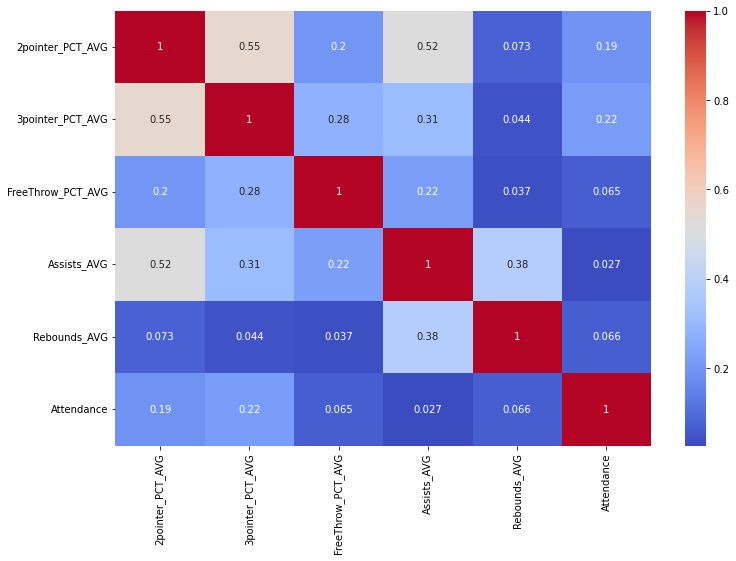

In [24]:
numv = X.columns
corr = X[numv].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True,cmap = 'coolwarm')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [26]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [27]:
for idx, col_name in enumerate(X_train.columns):
    print(f"The coefficient for {col_name} is {regression_model.coef_[idx]}")
intercept = regression_model.intercept_
print(f"The intercept for our model is {intercept}")
rsquare = regression_model.score(X_train, y_train)
rsquare_test = regression_model.score(X_test, y_test)
print(f"The R^2 for our model is {rsquare}")
print(f"The test R^2 for our model is {rsquare_test}")

The coefficient for 2pointer_PCT_AVG is 3.024401308335486
The coefficient for 3pointer_PCT_AVG is 1.6706332971720101
The coefficient for FreeThrow_PCT_AVG is 0.1464713733485043
The coefficient for Assists_AVG is -1.0853739718069113
The coefficient for Rebounds_AVG is 1.20858069184801
The coefficient for Attendance is 0.031699881366245075
The intercept for our model is -219.4135496153602
The R^2 for our model is 0.36534722570483136
The test R^2 for our model is 0.33062348080313764


In [28]:
X = add_constant(X)
OLS_model = OLS(y, X)
results = OLS_model.fit()

In [29]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   WINS   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     50.07
Date:                Fri, 20 May 2022   Prob (F-statistic):           8.62e-49
Time:                        13:14:58   Log-Likelihood:                -2030.5
No. Observations:                 540   AIC:                             4075.
Df Residuals:                     533   BIC:                             4105.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -202.2371     20.18

In [30]:
import pickle
filename = '../Models/Games_OLS.sav'
pickle.dump(OLS_model, open(filename, 'wb'))
filename = '../Models/Games_LinReg.sav'
pickle.dump(regression_model, open(filename, 'wb'))